In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
from pathlib import Path
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data / "mnist.pkl.gzip"

In [ ]:
import gzip
import pickle
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(x_train, y_train, x_valid, y_valid) = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


In [ ]:
x_train.shape

torch.Size([50000, 784])

In [ ]:
class MLP(nn.Module):
    px_size = 784
    def __init__(self, hidden_layers):
        super().__init__()
        
        layers = []
        inp_dim = self.px_size
        for hd in hidden_layers:
            layers += [nn.Linear(inp_dim, hd), nn.ReLU()]
            inp_dim = hd
            
        self.layers = nn.Sequential(*layers)
        self.clf = nn.Linear(inp_dim, 10)

    def forward(self, x):
        x = self.layers(x)
        return self.clf(x)


In [ ]:
def accuracy(xb, yb): return (xb.argmax(1) == yb).float().mean()

def fit():
    global model
    global opt
    global train_dl
    global val_dl
    epochs = 3
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        for xb, yb in train_dl:
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            

        with torch.no_grad():
            val_loss = []
            val_accuracy = []
            for xb, yb in val_dl:
                val_logits = model(xb)
                val_loss.append(F.cross_entropy(val_logits, yb))
                val_accuracy.append(accuracy(val_logits, yb))
                
            print(f"Loss: {sum(val_loss)/len(val_loss):.4f} Accuracy: {sum(val_accuracy)/len(val_loss):.4f}")
                

In [ ]:
class Optimizer:
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()


In [ ]:
model = MLP([50])
lr = 0.5
opt = Optimizer(model.parameters(), lr)
# opt = torch.optim.SGD(model.parameters(), lr)


In [ ]:
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        assert len(self.x) == len(self.y)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

train_ds = Dataset(x_train, y_train)
val_ds = Dataset(x_valid, y_valid)

In [ ]:
train_ds[:5]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [ ]:
import random

class Sampler:
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.ds = ds
        self.shuffle = shuffle

    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

ss = Sampler(train_ds, shuffle=False)
ss_shuf = Sampler(train_ds, shuffle=True)

for i, shuf_i in zip(ss, ss_shuf):
    if i > 10: break
    print(i, shuf_i)
    


0 40215
1 41436
2 42394
3 43081
4 4086
5 40560
6 5886
7 32179
8 6990
9 17200
10 22946


In [ ]:
from itertools import islice
islice?


Init signature: islice(self, /, *args, **kwargs)
Docstring:     
islice(iterable, stop) --> islice object
islice(iterable, start, stop[, step]) --> islice object

Return an iterator whose next() method returns selected values from an
iterable.  If start is specified, will skip all preceding elements;
otherwise, start defaults to zero.  Step defaults to one.  If
specified as another value, step determines how many values are
skipped between successive calls.  Works like a slice() on a list
but returns an iterator.
Type:           type
Subclasses:     

In [ ]:
it = iter(ss)

In [ ]:
list(islice(it, 5))

[0, 1, 2, 3, 4]

In [ ]:
class BatchSampler:
    def __init__(self, ss, bs, drop_last=False):
        self.ss = ss
        self.bs = bs
        self.drop_last = drop_last

    def __iter__(self):
        it = iter(self.ss)
        for x in iter(lambda: list(islice(it, self.bs)), []):
            if self.drop_last and len(x) != self.bs: return
            yield x

bs = 32
bss = BatchSampler(ss, bs, True)
bss_shuf = BatchSampler(ss_shuff, bs, True)

for i, shuf_i in zip(bss, bss_shuf):
    # print(i, shuf_i)
    # if sum(i) > 200: break
    pass
print(i)
print(shuf_i)
    

[49952, 49953, 49954, 49955, 49956, 49957, 49958, 49959, 49960, 49961, 49962, 49963, 49964, 49965, 49966, 49967, 49968, 49969, 49970, 49971, 49972, 49973, 49974, 49975, 49976, 49977, 49978, 49979, 49980, 49981, 49982, 49983]
[40489, 44411, 43007, 32938, 41946, 2304, 43158, 4095, 46328, 48436, 1679, 4819, 22716, 33533, 6656, 10875, 49498, 10366, 26464, 8355, 46382, 46754, 46082, 45732, 36317, 13727, 9019, 46363, 10898, 45888, 16574, 29098]


In [ ]:
def collate(x):
    xb, yb = zip(*x)
    return torch.stack(xb), torch.stack(yb)

class Dataloader:
    def __init__(self, ds, bss):
        self.ds = ds
        self.bss = bss

    def __iter__(self):
         for b in self.bss:
             yield collate([self.ds[i] for i in b])

dl = Dataloader(train_ds, bss_shuf)

for i, (xb, yb) in enumerate(dl):
    if i > 10: break
    print(xb.shape, yb.shape)


torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])


<matplotlib.image.AxesImage>

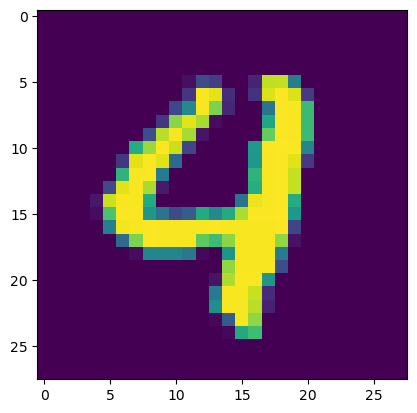

In [ ]:
import matplotlib.pyplot as plt
xb, yb = next(iter(dl))
plt.imshow(xb[0].view(28, 28))

In [ ]:
fit()

Epoch 0:
Loss: 0.1357 Accuracy: 0.9606
Epoch 1:
Loss: 0.1211 Accuracy: 0.9643
Epoch 2:
Loss: 0.1165 Accuracy: 0.9677
Epoch 3:
Loss: 0.1109 Accuracy: 0.9685
Epoch 4:
Loss: 0.1184 Accuracy: 0.9688
Epoch 5:
Loss: 0.1439 Accuracy: 0.9646
Epoch 6:
Loss: 0.1240 Accuracy: 0.9683
Epoch 7:
Loss: 0.1289 Accuracy: 0.9677


## PyTorch Modules

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler, RandomSampler

In [ ]:
# train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
# val_samp = BatchSampler(SequentialSampler(val_ds), bs, drop_last=False)
# train_dl = DataLoader(train_ds, batch_sampler=train_samp)
# val_dl = DataLoader(val_ds, batch_sampler=val_samp)

# as BatchSampler is so common, you can pass batch_size and sampler rather than batch_sampler 
# train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds))
# val_dl = DataLoader(val_ds, bs, sampler=SequentialSampler(val_ds))

# as RandomSampler is so common, you can just pass shuffle=True
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, bs, shuffle=False)

In [ ]:
fit()

Epoch 0:
Loss: 0.3271 Accuracy: 0.9675
Epoch 1:
Loss: 0.2844 Accuracy: 0.9691
Epoch 2:
Loss: 0.2976 Accuracy: 0.9693


In [ ]:
# we can also use BatchSampler as a sampler as the Dataset comes precollated
train_ds[[23,34,5]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 0, 2]))

In [ ]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds))

In [ ]:
it = iter(train_samp)
x, y = train_ds[next(it)]
x.shape, y.shape

(torch.Size([32, 784]), torch.Size([32]))

In [ ]:
it = iter(train_dl)
x,y = next(it)
print(x, y)
x.shape, y.shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([8, 1, 1, 2, 5, 9, 3, 4, 6, 8, 2, 1, 5, 8, 2, 4, 2, 3, 2, 7, 7, 0, 6, 9,
        6, 6, 5, 2, 0, 6, 5, 3])


(torch.Size([32, 784]), torch.Size([32]))

In [ ]:
fit()

Epoch 0:
Loss: 0.3254 Accuracy: 0.9682
Epoch 1:
Loss: 0.3413 Accuracy: 0.9702
Epoch 2:
Loss: 0.3184 Accuracy: 0.9691
